# Analysis of Multivariate Data - NHANES Case Study

We start with the usual import statements and notebook settings:

In [32]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

In [59]:
# Settings
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = 10,8
pd.set_option('display.width', 100)
plt.rcParams.update({'font.size': 18})

# We do this to ignore several specific warnings
warnings.filterwarnings('ignore')
sns.set_style('white')

# Disable jedi autocompleter
%config Completer.use_jedi = False

In [34]:
df = pd.read_csv("data/nhanes_2015_2016.csv")
df.sample(5)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
4539,91592,1.00,nan,nan,1,2,25,4,1.00,3.00,...,106.00,56.00,101.90,159.50,40.10,41.80,38.60,38.00,117.10,2.00
5693,93624,2.00,1.00,nan,2,1,41,4,1.00,3.00,...,100.00,58.00,60.90,165.60,22.20,39.80,36.00,30.40,76.00,nan
5601,93469,1.00,nan,3.00,1,1,50,2,1.00,2.00,...,118.00,62.00,86.70,176.80,27.70,37.60,40.10,36.20,98.50,nan
4096,90818,2.00,2.00,nan,2,1,22,4,1.00,4.00,...,114.00,76.00,92.60,171.00,31.70,44.10,37.40,34.90,94.40,nan
4841,92122,1.00,nan,3.00,2,1,23,3,1.00,4.00,...,114.00,76.00,73.60,176.10,23.70,44.20,36.80,29.60,86.30,2.00


## Quantitative Bivariate Data

Bivariate data arise when every "unit of analysis" (e.g. a person in the NHANES dataset) is assessed with respect to two traits (the NHANES subjects were assessed for many more than two traits, but we can consider two traits at a time here).

A scatterplot is a very common and easily-understood visualization of quantitative bivariate data. Below we make a scatterplot of arm length against leg length. This means that arm length (BMXARML) is plotted on the vertical axis and leg length (BMXLEG) is plotted on the horizontal axis). We see a positive dependence between the two measures -- people with longer arms tend to have longer legs, and vice-versa. However it is far from a perfect relationship.

<div class="alert alert-block alert-warning">
In a scatterplot with more than around 100 points, "overplotting" becomes an issue. This means that many points fall on top of each other in the plot, which obscures relationships in the middle of the distribution and over-emphasizes the extremes. One way to mitigate overplotting is to use an "alpha" channel to make the points semi-transparent, as we have done below.
</div>

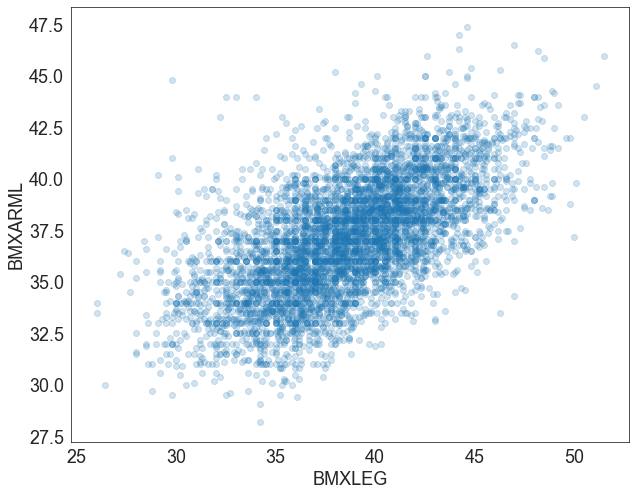

In [35]:
sns.regplot(x="BMXLEG", y="BMXARML", data=df, fit_reg=False, scatter_kws={"alpha": 0.2});

<div class="alert alert-block alert-info">
<b>Tip:</b> Another way to avoid overplotting is to make a plot of the "density" of points.</div>

In the plot below,the two plot margins show the densities for the arm lengths and leg lengths separately, while the plot shows their density jointly. It also shows the Pearson correlation coefficient between the two variable.

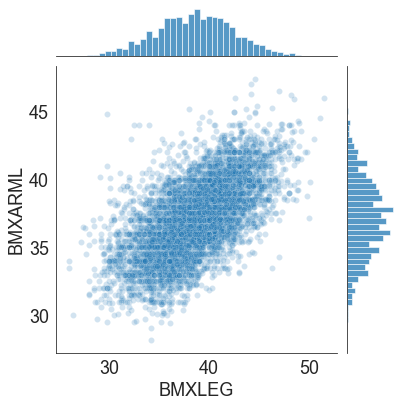

In [36]:
sns.jointplot(x="BMXLEG", y="BMXARML", kind='scatter', data=df, alpha= 0.2);

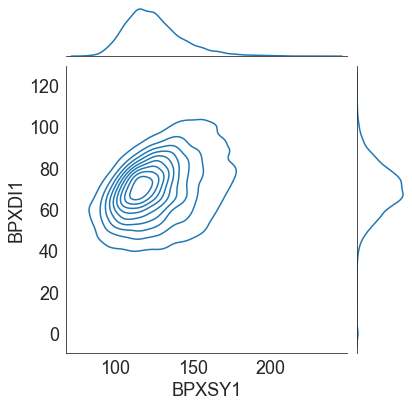

In [37]:
sns.jointplot(x="BPXSY1", y="BPXDI1", kind='kde', data=df)

Next we look at two repeated measures of systolic blood pressure, taken a few minutes apart on the same person. These values are very highly correlated, with a correlation coefficient of around 0.96.

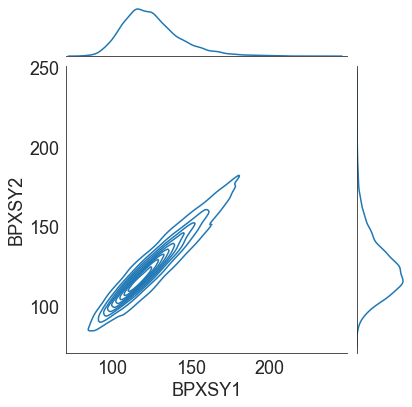

In [39]:
jp = sns.jointplot(x="BPXSY1", y="BPXSY2", kind='kde', data=df)

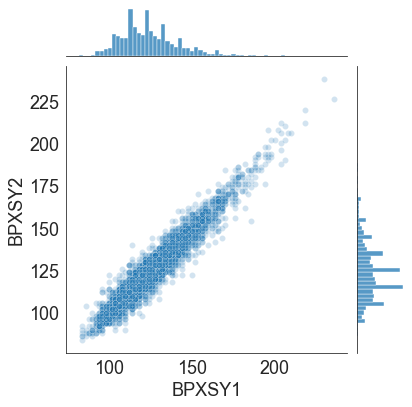

In [40]:
sns.jointplot(x="BPXSY1", y="BPXSY2", kind='scatter', data=df, alpha= 0.2);

## Heterogeneity and Stratification

Most human characteristics are complex -- they vary by gender, age, ethnicity, and other factors. This type of variation is often referred to as "heterogeneity". When such heterogeneity is present, it is usually productive to explore the data more deeply by stratifying on relevant factors, as we did in the univariate analyses.

Below, we continue to probe the relationship between leg length and arm length, stratifying first by gender, then by gender and ethnicity.  
The gender-stratified plot indicates that men tend to have somewhat longer arms and legs than women -- this is reflected in the fact that the cloud of points on the left is shifted slightly up and to the right relative to the cloud of points on the right. In addition, the correlation between arm length and leg length appears to be somewhat weaker in women than in men.

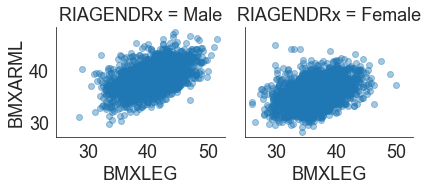

In [44]:
df["RIAGENDRx"] = df.RIAGENDR.replace({1: "Male", 2: "Female"}) 
sns.FacetGrid(df, col="RIAGENDRx").map(plt.scatter, "BMXLEG", "BMXARML", 
                                       alpha=0.4).add_legend();

In [50]:
print("Female")
print(df.loc[df.RIAGENDRx=="Female", ["BMXLEG", "BMXARML"]].dropna().corr())
print("-------")
print("Male")
print(df.loc[df.RIAGENDRx=="Male", ["BMXLEG", "BMXARML"]].dropna().corr())

Female
         BMXLEG  BMXARML
BMXLEG     1.00     0.43
BMXARML    0.43     1.00
-------
Male
         BMXLEG  BMXARML
BMXLEG     1.00     0.51
BMXARML    0.51     1.00


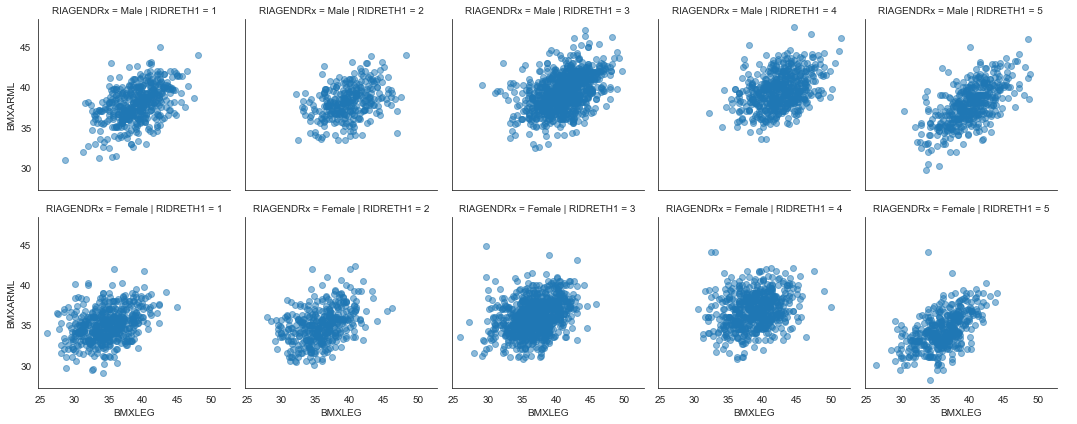

In [54]:
plt.rcParams.update({'font.size': 10})
_ = sns.FacetGrid(df, col="RIDRETH1",  row="RIAGENDRx").map(plt.scatter, "BMXLEG", "BMXARML", alpha=0.5).add_legend()

## Categorical Bivariate Data

We could start with a contingency table, which counts the number of people having each combination of two factors. To illustrate, we will consider the NHANES variables for marital status and education level.

First, we create new versions of these two variables using text labels instead of numbers to represent the categories. We also create a new data set that omits people who responded "Don't know" or who refused to answer these questions.

In [55]:
df["DMDEDUC2x"] = df.DMDEDUC2.replace({1: "<9", 2: "9-11", 3: "HS/GED", 4: "Some college/AA", 5: "College", 
                                       7: "Refused", 9: "Don't know"})
df["DMDMARTLx"] = df.DMDMARTL.replace({1: "Married", 2: "Widowed", 3: "Divorced", 4: "Separated", 5: "Never married",
                                      6: "Living w/partner", 77: "Refused"})
db = df.loc[(df.DMDEDUC2x != "Don't know") & (df.DMDMARTLx != "Refused"), :]

In [57]:
x = pd.crosstab(db.DMDEDUC2x, df.DMDMARTLx)
x

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,62,80,305,117,39,40
<9,52,66,341,65,43,88
College,120,85,827,253,22,59
HS/GED,127,133,550,237,40,99
Some college/AA,217,163,757,332,42,108


The results will be easier to interpret if we normalize the data.  
<div class="alert alert-block alert-info">
<b>A contingency table can be normalized in three ways -- we can make the rows sum to 1, the columns sum to 1, or the whole table sum to 1.</div>

Below we normalize within rows. This gives us the proportion of people in each educational attainment category who fall into each group of the marital status variable.

In [58]:
x.apply(lambda z: z/z.sum(), axis=1)

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,0.10,0.12,0.47,0.18,0.06,0.06
<9,0.08,0.10,0.52,0.10,0.07,0.13
College,0.09,0.06,0.61,0.19,0.02,0.04
HS/GED,0.11,0.11,0.46,0.20,0.03,0.08
Some college/AA,0.13,0.10,0.47,0.21,0.03,0.07


The proportion of people who are married varies substantially, and is notably higher for college graduates (around 61%) compared to groups with lower educational attainment.

We can also normalize within the columns instead of normalizing within the rows. This gives us the proportion of people with each marital status group who have each level of educational attainment.

In [60]:
x.apply(lambda z: z/z.sum(), axis=0)

DMDMARTLx,Divorced,Living w/partner,Married,Never married,Separated,Widowed
DMDEDUC2x,,,,,,
9-11,0.11,0.15,0.11,0.12,0.21,0.10
<9,0.09,0.13,0.12,0.06,0.23,0.22
College,0.21,0.16,0.30,0.25,0.12,0.15
HS/GED,0.22,0.25,0.20,0.24,0.22,0.25
Some college/AA,0.38,0.31,0.27,0.33,0.23,0.27


It is quite plausible that there are gender differences in the relationship between educational attainment and marital status. Therefore we can look at the proportion of people in each marital status category, for each combination of the gender and education variables.

In [61]:
# The following line does these steps, reading the code from left to right:
# 1 Group the data by every combination of gender, education, and marital status
# 2 Count the number of people in each cell using the 'size' method
# 3 Pivot the marital status results into the columns (using unstack)
# 4 Fill any empty cells with 0
# 5 Normalize the data by row
db.groupby(["RIAGENDRx", "DMDEDUC2x", "DMDMARTLx"]).size().unstack().fillna(0).apply(lambda x: x/x.sum(), axis=1)

DMDMARTLx                  Divorced  Living w/partner  Married  Never married  Separated  Widowed
RIAGENDRx DMDEDUC2x                                                                              
Female    9-11                 0.11              0.12     0.41           0.17       0.08     0.10
          <9                   0.09              0.09     0.42           0.11       0.09     0.19
          College              0.11              0.06     0.58           0.18       0.02     0.06
          HS/GED               0.12              0.11     0.41           0.19       0.04     0.13
          Some college/AA      0.15              0.10     0.42           0.21       0.03     0.09
Male      9-11                 0.08              0.12     0.53           0.19       0.05     0.03
          <9                   0.07              0.11     0.63           0.09       0.04     0.07
          College              0.06              0.07     0.64           0.19       0.02     0.03
          HS/GED               0.09              0.11     0.51           0.21       0.03     0.04
          Some college/AA      0.12              0.10     0.53           0.20       0.02     0.04

This analyses yields some interesting trends, notably that women are much more likely to be widowed or divorced than men (e.g. women in the HS/GED group are around 3 times more likely to be widowed than men in the HS/GED group).  
We conclude this section by noting that marital status is associated with many factors, including gender and eduational status, but also varies strongly by age and birth cohort. However, many questions couldn't be answered with this data. We need more information, like how many times have they married. As a matter of fact, society is changing, so is marriage.

<div class="alert alert-block alert-warning">
Another situation that commonly arises in data analysis is when we wish to analyze bivariate data consisting of one quantitative and one categorical variable.</div>

## Mixed Categorical and Quantitative Data

To illustrate methods that can be used in this setting, we consider the relationship between marital status and age in the NHANES data. Specifically, we consider the distribution of ages for people who are currently in each marital status category. A natural tool in this setting is side-by-side boxplots.

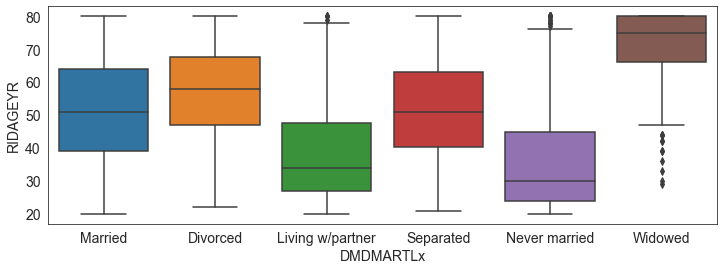

In [66]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 14})
a = sns.boxplot(db.DMDMARTLx, db.RIDAGEYR)

When we have enough data, a "violinplot" gives a bit more insight into the shapes of the distributions compared to a traditional boxplot.

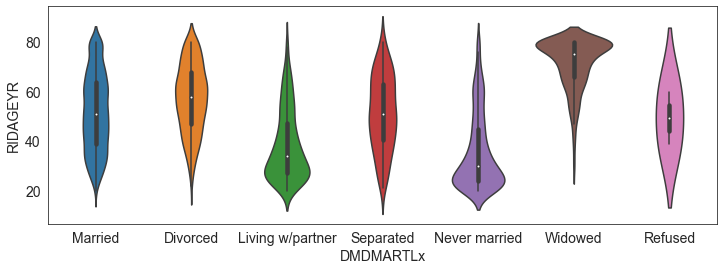

In [65]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 14})
a = sns.violinplot(df.DMDMARTLx, df.RIDAGEYR)

The violinplot above is based on the same data as the boxplot above. We can see quite clearly that the distributions with low mean (living with partner, never married) are strongly right-skewed, while the distribution with high mean (widowed) is strongly left-skewed. The other distributions have intermediate mean values, and are approximately symmetrically distributed. Note also that the never-married distribution has a long shoulder, suggesting that this distributions includes many people who are never-married because they are young, and have not yet reached the ages when people typically marry, but also a substantial number of people will marry for the first time anywhere from their late 30's to their mid-60's.